In [1]:
import itertools
from copy import deepcopy

In [2]:
import ipysheet
from ipysheet.pandas_loader import to_dataframe

In [3]:
import sys
sys.path.append("../") # go to parent dir

In [4]:
from util.convert import process_aspif
from util.display import symbol_to_str, display_explanation_graph
from util.explain import Literal, preprocess, explanation_graph, get_minimal_assumptions, negation_atoms
from util.run import solve

In [5]:
import networkx as nx

In [6]:
import clingo

In [7]:
import subprocess

## Input

In [8]:
rows,columns = 6,1

In [44]:
#facts_sheet = ipysheet.sheet(rows=rows, columns=columns)


def generate_ipy(rows, columns):
    sheet = ipysheet.sheet(rows=rows, columns=columns)
    for row in range(rows):
        for column in range(columns):
            ipysheet.cell(row, column, "")
    return sheet

"""
cells = []

for row in range(rows):
    cell_range = []
    for column in range(columns):
        cell = ipysheet.cell(row, column, "")
        cell_range.append(cell)
    cells.append(cell_range)

#cells[0][0] = ipysheet.cell(0,0, "a")
cells[4][0] = ipysheet.cell(4,0, "e")
"""
facts_sheet = generate_ipy(rows, columns)
ipysheet.cell(4,0, "e")
facts_sheet

Sheet(cells=(Cell(column_end=0, column_start=0, row_end=0, row_start=0, type='text', value=''), Cell(column_en…

In [45]:
df = to_dataframe(facts_sheet)
df

,A
0,
1,
2,
3,
4,e
5,


In [46]:
facts_list = list(itertools.chain(*df[df != ""].dropna().values.tolist()))
facts_list

['e']

## Programm

In [47]:
facts = '\n'.join(map(lambda f: f"{f}.", facts_list))
facts

'e.'

In [48]:
program = """
a :- k, not b.
k :- e, not b.
c :- a, b.

b :- not a.
c :- k.
f :- e, not k, not c.
"""
program

'\na :- k, not b.\nk :- e, not b.\nc :- a, b.\n\nb :- not a.\nc :- k.\nf :- e, not k, not c.\n'

## Answer Sets

In [49]:
answer_sets_clingo, models_clingo = solve((facts, program))

Answer  1: { b e f }.
Answer  2: { a c e k }.
SAT 2 


In [50]:
answer_sets_clingo

[{Function('b', [], True), Function('e', [], True), Function('f', [], True)},
 {Function('a', [], True),
  Function('c', [], True),
  Function('e', [], True),
  Function('k', [], True)}]

In [51]:
results_sheet = ipysheet.sheet(rows=max(len(answer_set) for answer_set in answer_sets_clingo), columns=len(answer_sets_clingo))


for c, answer_set in enumerate(answer_sets_clingo):
    for r, atom in enumerate(answer_set):
        ipysheet.cell(r, c, symbol_to_str(atom))

results_sheet

Sheet(cells=(Cell(column_end=0, column_start=0, row_end=0, row_start=0, type='text', value='b'), Cell(column_e…

## Grounding

In [53]:
groundable_facts = list(map(lambda f: f"#external {f}.", facts_list))

with open('asp_to_ground.lp', 'w') as file:
    file.write("% Facts:\n")
    file.writelines(groundable_facts)
    file.write("% Rules:\n")
    file.write(program)

In [54]:
output = subprocess.run(['gringo', 'asp_to_ground.lp'], stdout=subprocess.PIPE)


In [55]:
aspif = output.stdout.decode('utf-8')
print(aspif)

asp 1 0 0
5 1 2
1 0 1 2 0 1 -3
1 0 1 4 0 2 -2 1
1 0 1 3 0 2 -2 4
1 0 1 5 0 2 2 3
1 0 1 5 0 1 4
1 0 1 6 0 3 -5 -4 1
4 1 e 1 1
4 1 b 1 2
4 1 k 1 4
4 1 a 1 3
4 1 c 1 5
4 1 f 1 6
0



In [56]:
program_dict = {}
literal_dict = {}

In [57]:
process_aspif(aspif, program_dict, literal_dict)

({e: [{'positive': [], 'negative': []}],
  b: [{'positive': [], 'negative': [a]}],
  k: [{'positive': [e], 'negative': [b]}],
  a: [{'positive': [k], 'negative': [b]}],
  c: [{'positive': [b, a], 'negative': []}, {'positive': [k], 'negative': []}],
  f: [{'positive': [e], 'negative': [c, k]}]},
 {1: e, 2: b, 4: k, 3: a, 5: c, 6: f})

In [58]:
answer_sets = [{Literal.literal_from_symbol(elem) for elem in answer_set} for answer_set in answer_sets_clingo]
answer_sets

[{b, e, f}, {a, c, e, k}]

In [59]:
cautious_consequence = deepcopy(answer_sets[0])
for answer_set in answer_sets[1:]:
    cautious_consequence.intersection_update(answer_set)
cautious_consequence

{e}

In [60]:
facts_literals = {Literal.literal_from_string(fact) for fact in facts_list}
facts_literals

{e}

In [61]:
derivable_dict = preprocess(program_dict, facts_literals, answer_sets[0])
derivable_dict

{e: [{'T'}],
 b: [{~a}],
 ~k: [frozenset({b})],
 ~a: [frozenset({~k}), frozenset({b})],
 ~c: [frozenset({~a, ~k})],
 f: [{~c, ~k, e}]}

In [62]:
minimal_assumptions = list(get_minimal_assumptions(deepcopy(cautious_consequence), negation_atoms(program_dict), deepcopy(derivable_dict), answer_sets[0]))
minimal_assumptions

[frozenset({k}), frozenset({a})]

In [63]:
f = Literal.literal_from_string('f')

In [64]:
graph = explanation_graph(f, deepcopy(derivable_dict), deepcopy(minimal_assumptions[0]), deepcopy(answer_sets[0]))
assert graph is not None

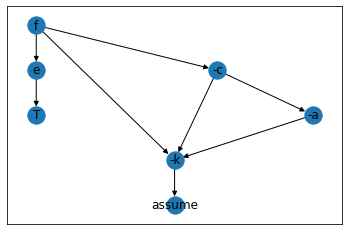

In [65]:
display_explanation_graph(graph, f)

In [ ]:
graph.edges(data=True)